# Surface Defects Classification

One notable application of AI in industry is **Computer Vision** (CV), which is particularly effective for defect detection and classification. This technology aids in the early diagnosis of complex and costly machinery.

In this project, images of hot-rolled steel strip surfaces are analyzed to identify and classify six common defect types: crazing (Cr), inclusion (In), patches (Pa), pitted surface (PS), rolled-in scale (RS), and scratches (Sc).

The project focuses on exploring a single model and its architecture, specifically the **Convolutional Neural Network** (CNN). CNNs have demonstrated significant effectiveness in solving CV problems. Among the various advanced CNN architectures available, `ResNet50`, with its 50 layers, is used for defect classification in this project.

The data for this analysis is sourced from the [NEU Surface Defect Database](http://faculty.neu.edu.cn/yunhyan/NEU_surface_defect_database.html).

1. [Data Exploration](#explore)
2. [Data Preparation](#prepare)
3. [Model Building](#build)
4. [Model Training](#train)
5. [Model Evaluation](#evaluate)
6. [Conclusion](#conclude)

## IMPORT LIBRARY

In [ ]:
# import libraries

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.metrics import confusion_matrix, classification_report
from random import randint
from PIL import Image, ImageDraw

%matplotlib inline

from tensorflow.keras import applications, Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

<a id="explore"></a>
## Data Exploration

6 classes:
['crazing', 'inclusion', 'patches', 'pitted', 'rolled', 'scratches']


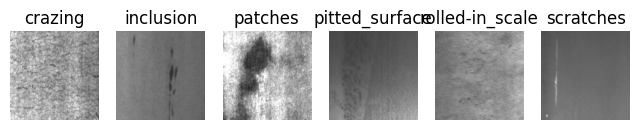

In [ ]:
# Specify the path to the IMAGES folder
data_folder = r'C:\Users\afifa\ImageDetection\IMAGE'

# Get the class names (subfolder names)
classes = [d for d in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, d)) and not d.startswith('.')]
classes.sort()
print(len(classes), 'classes:')
print(classes)
# Show the first image in each folder
fig = plt.figure(figsize=(8, 10))
i = 0
for sub_dir in classes:
    sub_dir_path = os.path.join(data_folder, sub_dir)
    img_files = os.listdir(sub_dir_path)
    if img_files:  # Check if the list is not empty
        img_file = img_files[0]  # Get the first image file
        img_path = os.path.join(sub_dir_path, img_file)  # Construct the full path to the image
        img = mpimg.imread(img_path)  # Read the image
        a = fig.add_subplot(1, len(classes), i + 1)  # Add a subplot for each class
        a.axis('off')  # Hide axis
        imgplot = plt.imshow(img)  # Display the image
        a.set_title(img_file.replace('_1.jpg', ''))  # Set the title of the subplot
        i += 1
    else:
        print(f"No images found in folder: {sub_dir_path}")

plt.show()


<a id="prepare"></a>
## Data Preparation

Before training the model, the data must be prepared. This involves normalizing the feature values by dividing them by 255 to scale them to floating-point values between 0 and 1. The dataset is then split so that 70% is used for training the model, while the remaining 30% is reserved for validation. During data loading, a data generator assigns 'one-hot encoded' numeric labels to each image based on its class, as determined by the subfolders where the data is organized. In this case, there are six subfolders: *crazing*, *inclusion*, *patches*, *pitted*, *rolled*, and *scratches*. Consequently, each label consists of six binary values (0 or 1) indicating the class to which the image belongs. For example, the label [0 1 0 0 0 0] signifies that the image is from the second class (*inclusion*).

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Specify the path to the IMAGES folder
data_folder = r'C:\Users\afifa\ImageDetection\IMAGE'

# Filter out hidden directories
def filter_directories(path):
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d)) and not d.startswith('.')]

# Get the class names (subfolder names) after filtering
classes = filter_directories(data_folder)
classes.sort()
print(len(classes), 'classes:')
print(classes)

img_size = (200, 200)
batch_size = 20

print("Getting Data...")
datagen = ImageDataGenerator(
    rescale=1/255.0, # Normalize pixel values
    rotation_range=30, # Add rotated images
    vertical_flip=True, # Vertically flip images
    validation_split=0.3 # Hold back 30% of the images for validation
)

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training', # Set as training data
    classes=classes # Specify filtered classes
)

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation', # Set as validation data
    classes=classes # Specify filtered classes
)

classnames = list(train_generator.class_indices.keys())
print('Data generators ready')
print('Class names:', classnames)


6 classes:
['crazing', 'inclusion', 'patches', 'pitted', 'rolled', 'scratches']
Getting Data...
Preparing training dataset...
Found 1260 images belonging to 6 classes.
Preparing validation dataset...
Found 540 images belonging to 6 classes.
Data generators ready
Class names: ['crazing', 'inclusion', 'patches', 'pitted', 'rolled', 'scratches']


<a id="build"></a>
##  Model Building

To classify the defects, the **ResNet50** CNN architecture is used.  For this reason, the **transfer learning** technique is used to import the state-of-the-art CNN model architecture, and then add the top layers.The layers of the ResNet50 model are partially frozen to prevent their weights from being updated during training. Specifically, all layers except the last few (10 in this case) are set to non-trainable. Also, Dropout Layer is applied with a rate of 0.4 to prevent overfitting since the data here is not really large.



In [ ]:
from tensorflow.keras import applications, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input

# Define input layer
inputs = Input(shape=(200, 200, 3))

# Load the ResNet50 base model
base_model = applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=inputs
)

# Refreeze all layers except the last few
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Define the custom model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)
outputs = Dense(len(classes), activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 206, 206,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 100, 100,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 100, 100,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 102, 102,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 50, 50,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 50, 50,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 50, 50,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 50, 50,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,798 (91.99 MB)

 Trainable params: 4,991,750 (19.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

<a id="train"></a>
## Model Training

The model is trained over 100 epochs, making use of both training and validation sets.

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=100,  # Adjust based on performance
    validation_data=validation_generator,
)

Epoch 1/100


C:\Users\afifa\anaconda3\envs\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.1754 - loss: 6.3725 - val_accuracy: 0.1667 - val_loss: 6.2617
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.2905 - loss: 6.0805 - val_accuracy: 0.1667 - val_loss: 6.1346
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.3713 - loss: 5.8362 - val_accuracy: 0.2037 - val_loss: 6.0430
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.4841 - loss: 5.5685 - val_accuracy: 0.1667 - val_loss: 5.9667
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.5580 - loss: 5.2913 - val_accuracy: 0.3722 - val_loss: 5.7243
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6470 - loss: 5.1047 - val_accuracy: 0.3611 - val_loss: 5.5127
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7201 - loss: 4.8779 - val_accuracy: 0.3648 - val_loss: 5.3009
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7383 - loss: 4.6929 - val_accuracy: 0.4611 - val_loss: 4.9

<a id="evaluate"></a>
## Model Evaluation

To evaluate the model, we plot the **loss** and **accuracy** histories for both the **training** and **validation** datasets.

The classification accuracy is further examined using a **confusion matrix**, which reveals which defects are identified with the highest and lowest accuracy. Additionally, a **classification report** is generated to assess **precision, recall, and F1-score**, which combines these two metrics. These evaluations can be performed using the `scikit-learn` library.

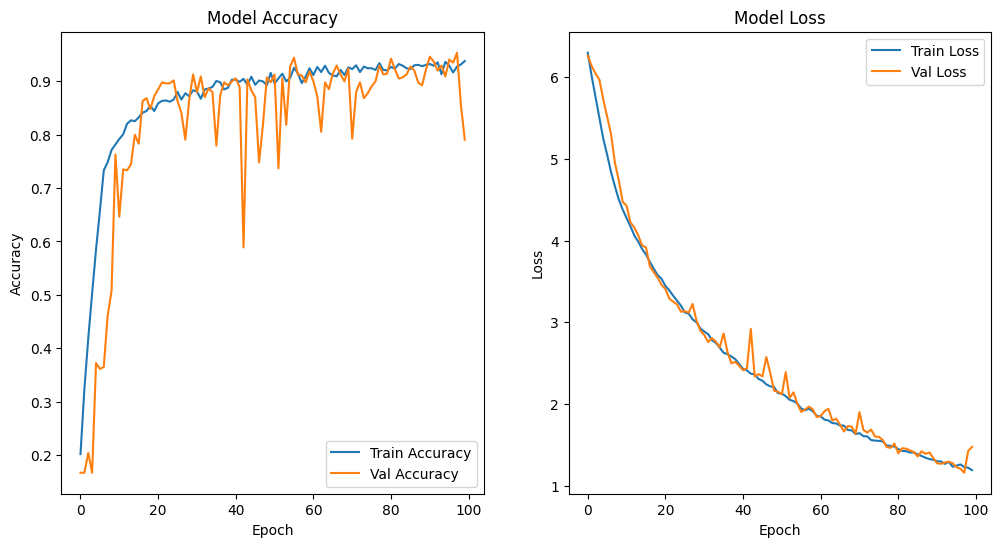

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


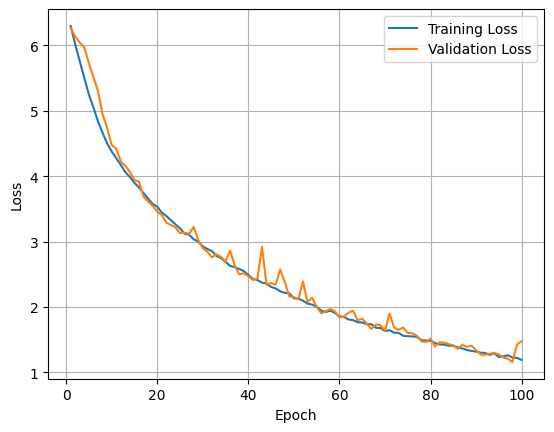

In [ ]:
# Plot the loss and validation loss
epochs = range(1, len(history.history['loss']) + 1)  # Get the number of epochs from the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


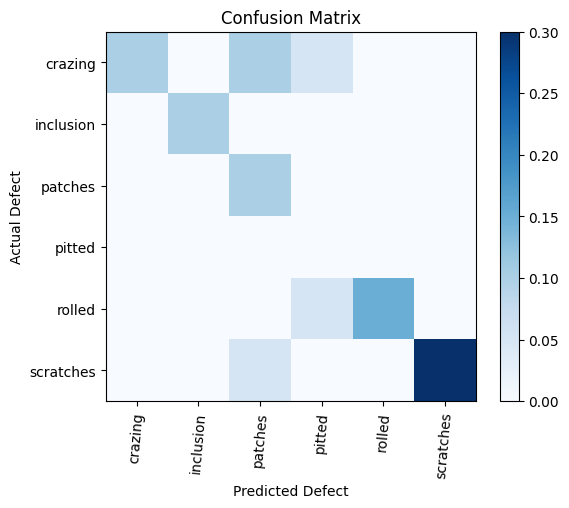

              precision    recall  f1-score   support

     crazing       1.00      0.40      0.57         5
   inclusion       1.00      1.00      1.00         2
     patches       0.40      1.00      0.57         2
      pitted       0.00      0.00      0.00         0
      rolled       1.00      0.75      0.86         4
   scratches       1.00      0.86      0.92         7

    accuracy                           0.75        20
   macro avg       0.73      0.67      0.65        20
weighted avg       0.94      0.75      0.79        20



C:\Users\afifa\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\afifa\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\afifa\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Ensure 'classnames' is defined (a list of class names, should match 'classes' used in model output)
classnames = list(classes)  # Assuming 'classes' is already defined

# Get validation data from the generator
x_test, y_test = validation_generator[0]  # Get the first batch of validation data

# Predict the class probabilities for the test data
class_probabilities = model.predict(x_test)

# Get the predicted and true class labels
predictions = np.argmax(class_probabilities, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions, normalize='all')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel('Predicted Defect')
plt.ylabel('Actual Defect')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(true_labels, predictions, target_names=classnames))


## Random Image Prediction and Visualization with the Prediction Model

6 classes:
['crazing', 'inclusion', 'patches', 'pitted', 'rolled', 'scratches']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


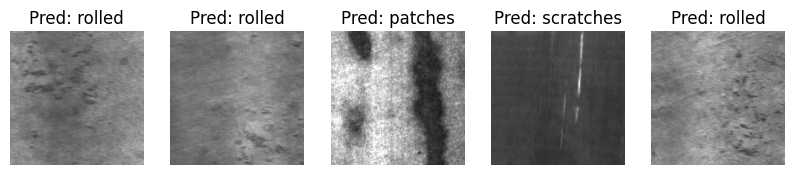

In [ ]:
import os
import random
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to the IMAGES folder
data_folder = r'C:\Users\afifa\ImageDetection\IMAGE'

# Get the class names (subfolder names)
classes = [d for d in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, d)) and not d.startswith('.')]
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Function to randomly select an image from a specific class
def get_random_image_from_class(data_folder, class_name):
    class_dir = os.path.join(data_folder, class_name)
    if not os.path.exists(class_dir):
        print(f"Directory {class_dir} does not exist.")
        return None
    img_files = os.listdir(class_dir)
    if not img_files:
        print(f"No images found in {class_dir}.")
        return None
    random_img = random.choice(img_files)
    random_img_path = os.path.join(class_dir, random_img)
    return random_img_path

# Function to predict randomly selected images
def predict_random_images(model, data_folder, classes, num_images=5):
    selected_images = []
    predictions = []

    for _ in range(num_images):
        # Randomly choose a class
        random_class = random.choice(classes)

        # Randomly select an image from the chosen class
        img_path = get_random_image_from_class(data_folder, random_class)
        if img_path is None:
            continue

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(200, 200))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        # Make a prediction with the model
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)[0]
        class_label = classes[predicted_class]

        # Store the image path and its prediction
        selected_images.append(img_path)
        predictions.append(class_label)

    return selected_images, predictions

# Call the function to predict randomly selected images
num_images_to_predict = 5
image_paths, prediction_results = predict_random_images(model, data_folder, classes, num_images=num_images_to_predict)

# Display the predicted images and their results
fig = plt.figure(figsize=(10, 5))
for i in range(len(image_paths)):
    img_path = image_paths[i]
    prediction_result = prediction_results[i]

    img = mpimg.imread(img_path)
    ax = fig.add_subplot(1, len(image_paths), i + 1)
    ax.imshow(img)
    ax.set_title(f"Pred: {prediction_result}")
    ax.axis('off')

plt.show()


<a id="conclude"></a>
# Conclusion

As the training and validation sets do not have many examples (each defect has 300 images, divided into 210 and 90 used for training and validation respectively), the CNN is able to determine the main features of each defect and, thus, have relative high accuracy.